In [1]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

In [2]:
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX 660 (CNMeM is disabled, cuDNN 5005)


# MNIST

About the dataset/problem: http://yann.lecun.com/exdb/mnist/

Several tweaks and ideas:

http://euler.stat.yale.edu/~tba3/stat665/lectures/lec18/notebook18.html

Visualization of bad predictions, data augmentation, loading weights (VGG-19 Model), OverFeat, GoogLeNet, Batch Normalization, Pure convolution

# Simple DNN

https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb

Trains a simple deep NN on the MNIST dataset.
Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.

In [264]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

In [265]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


Here we'll do a simple 3 layer fully connected network.

Keras is built on top of Theano (and now TensorFlow as well), both packages that allow you to define a computation graph in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your loss function and your optimizer. The loss function we'll use here is called categorical crossentropy, and is a loss function well-suited to comparing two probability distributions.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution.
https://en.wikipedia.org/wiki/Cross_entropy

The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". We won't discuss this in too much detail, but "adam" is often a good choice (developed here at U of T).

In [266]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
# An "activation" is just a non-linear function applied to the output of the layer above. 
# Here, with a "rectified linear unit", we clamp all values below 0 to 0.
model.add(Dropout(0.2))
# Dropout helps protect the model from memorizing or "overfitting" the training data

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
# This special "softmax" activation among other things,
# ensures the output is a valid probaility distribution, that is
# that its values are all non-negative and sum to 1.

#model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

This is the fun part: you can feed the training data loaded in earlier into this model and it will learn to classify digits

In [268]:
%%time

history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10,
                    verbose=2, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
2s - loss: 0.0172 - acc: 0.9942 - val_loss: 0.0832 - val_acc: 0.9817
Epoch 2/10
2s - loss: 0.0158 - acc: 0.9949 - val_loss: 0.0847 - val_acc: 0.9820
Epoch 3/10
1s - loss: 0.0174 - acc: 0.9941 - val_loss: 0.0665 - val_acc: 0.9841
Epoch 4/10
2s - loss: 0.0145 - acc: 0.9952 - val_loss: 0.0850 - val_acc: 0.9828
Epoch 5/10
1s - loss: 0.0158 - acc: 0.9948 - val_loss: 0.0765 - val_acc: 0.9842
Epoch 6/10
2s - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0868 - val_acc: 0.9817
Epoch 7/10
1s - loss: 0.0158 - acc: 0.9949 - val_loss: 0.0905 - val_acc: 0.9832
Epoch 8/10
1s - loss: 0.0126 - acc: 0.9961 - val_loss: 0.0881 - val_acc: 0.9825
Epoch 9/10
2s - loss: 0.0136 - acc: 0.9954 - val_loss: 0.0864 - val_acc: 0.9834
Epoch 10/10
2s - loss: 0.0141 - acc: 0.9954 - val_loss: 0.0942 - val_acc: 0.9825
Test score: 0.0942367353918
Test accuracy: 0.9825
CPU times: user 15.1 s, sys: 5.23 s, total: 20.3 s
Wall time: 20.3 s


### Checking misclassifications

In [357]:
from matplotlib.pyplot import *


def inspect_classification_results(model, X_test, y_test):
    # The predict_classes function outputs the highest probability class
    # according to the trained classifier for each input example
    predicted_classes = model.predict_classes(X_test, verbose=0)

    # Check which items we got right / wrong
    correct_indices = np.nonzero(predicted_classes == y_test)[0]
    incorrect_indices = np.nonzero(predicted_classes != y_test)[0]    
    
    if X_test.ndim==2:
        X_test_new = X_test.reshape(X_test.shape[0], 
                                np.sqrt(X_test.shape[1]), 
                                np.sqrt(X_test.shape[1]))
    elif X_test.ndim==4:
        X_test_new = X_test.squeeze()
        
    fig1 = figure(figsize=(14,3))
    fig1.suptitle("Correct classifications", fontsize=16)
    num_corr = correct_indices.shape[0]
    if num_corr>0:
        rand_indices1 = np.random.randint(0, num_corr, (6))
        for i, correct in enumerate(correct_indices[rand_indices1]):
            subplot(1,6,i+1)
            imshow(X_test_new[correct], cmap='gray', interpolation='none')
            title("Predicted {}, Class {}".format(predicted_classes[correct], 
                                                  y_test[correct]))
    
    fig2 = figure(figsize=(14,3))
    fig2.suptitle("Misclassifications", fontsize=16)
    num_incorr = incorrect_indices.shape[0]
    if num_incorr>0:
        rand_indices2 = np.random.randint(0, num_incorr, (6))
        for i, incorrect in enumerate(incorrect_indices[rand_indices2]):
            subplot(1,6,i+1)
            imshow(X_test_new[incorrect], cmap='gray', interpolation='none')
            title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

    print ("{:} correct classifications".format(correct_indices.shape[0]))
    print ("{:} incorrect classifications".format(incorrect_indices.shape[0]))

1128 correct classifications
8872 incorrect classifications


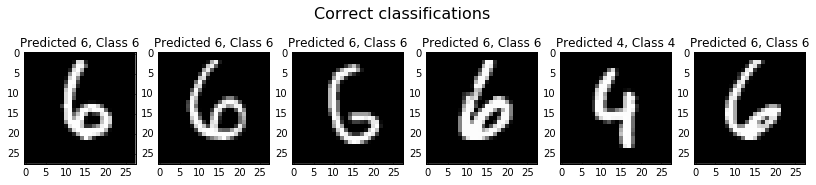

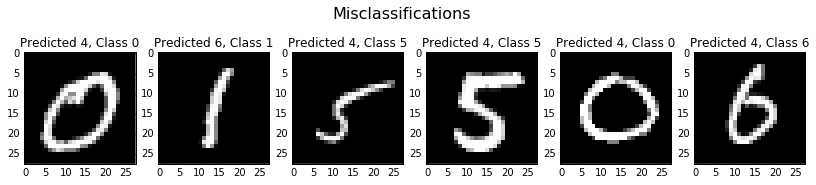

In [360]:
inspect_classification_results(model, X_test, y_test)

0.983 is probably the best we can do with a NN (MLP). A big problem of this model is the location dependancy. If the numbers are not centered then this will fail big way. The location invariance is one of the big pluses we get with a convolutional NN. 

For an MLP in pure python: https://github.com/meet-vora/mlp-classifier

# CONVNET

Read "Deep learning tutorial (theano) (UMontreal)" chapter of convolutional neural networks.

http://ml4a.github.io/guides/convolutional_neural_networks/

In [346]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

In [347]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [348]:
# cuda-convnet convolution implementation is optimised for minibatch sizes 
# that are multiples of 128.
batch_size = 128
nb_classes = 10
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

In [349]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

(60000, 28, 28)


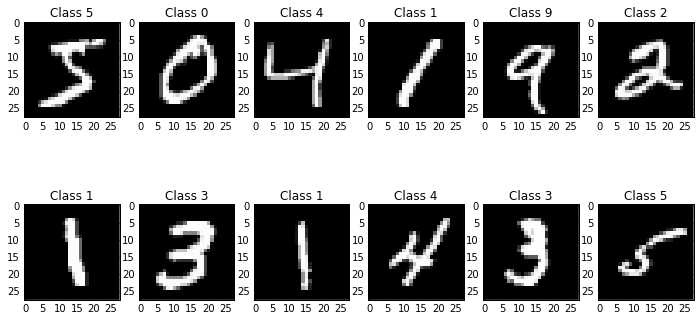

In [249]:
%matplotlib inline

from matplotlib.pyplot import *

print(X_train.shape)

figure(figsize=(12, 6))
for i in range(12):
    subplot(2,6,i+1)
    imshow(X_train[i], cmap='gray', interpolation='none')
    title("Class {}".format(y_train[i]))

In [350]:
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


Modify the target matrices to be in the one-hot format, i.e.
```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
etc.


In [351]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [245]:
Y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.

In [88]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [89]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

With optimizer 'adadelta'

In [33]:
%%time

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 85s - loss: 0.3948 - acc: 0.8805 - val_loss: 0.1005 - val_acc: 0.9678
Epoch 2/12
60000/60000 [==============================] - 89s - loss: 0.1478 - acc: 0.9562 - val_loss: 0.0655 - val_acc: 0.9799
Epoch 3/12
60000/60000 [==============================] - 84s - loss: 0.1122 - acc: 0.9666 - val_loss: 0.0528 - val_acc: 0.9828
Epoch 4/12
60000/60000 [==============================] - 84s - loss: 0.0942 - acc: 0.9722 - val_loss: 0.0457 - val_acc: 0.9852
Epoch 5/12
60000/60000 [==============================] - 84s - loss: 0.0814 - acc: 0.9758 - val_loss: 0.0414 - val_acc: 0.9860
Epoch 6/12
60000/60000 [==============================] - 82s - loss: 0.0718 - acc: 0.9782 - val_loss: 0.0401 - val_acc: 0.9867
Epoch 7/12
60000/60000 [==============================] - 84s - loss: 0.0662 - acc: 0.9809 - val_loss: 0.0355 - val_acc: 0.9878
Epoch 8/12
60000/60000 [==============================

With optimizer 'adagrad':

In [89]:
model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])

In [90]:
%%time

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 83s - loss: 0.2345 - acc: 0.9288 - val_loss: 0.0632 - val_acc: 0.9805
Epoch 2/12
60000/60000 [==============================] - 83s - loss: 0.1018 - acc: 0.9696 - val_loss: 0.0471 - val_acc: 0.9840
Epoch 3/12
60000/60000 [==============================] - 81s - loss: 0.0802 - acc: 0.9759 - val_loss: 0.0398 - val_acc: 0.9866
Epoch 4/12
60000/60000 [==============================] - 85s - loss: 0.0707 - acc: 0.9789 - val_loss: 0.0362 - val_acc: 0.9879
Epoch 5/12
60000/60000 [==============================] - 83s - loss: 0.0621 - acc: 0.9811 - val_loss: 0.0334 - val_acc: 0.9880
Epoch 6/12
60000/60000 [==============================] - 82s - loss: 0.0544 - acc: 0.9837 - val_loss: 0.0322 - val_acc: 0.9890
Epoch 7/12
60000/60000 [==============================] - 82s - loss: 0.0510 - acc: 0.9844 - val_loss: 0.0310 - val_acc: 0.9899
Epoch 8/12
60000/60000 [==============================

With optimizer 'RMSprop'

In [91]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [92]:
%%time

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 86s - loss: 0.0580 - acc: 0.9829 - val_loss: 0.0348 - val_acc: 0.9883
Epoch 2/12
60000/60000 [==============================] - 79s - loss: 0.0529 - acc: 0.9841 - val_loss: 0.0341 - val_acc: 0.9887
Epoch 3/12
60000/60000 [==============================] - 83s - loss: 0.0537 - acc: 0.9844 - val_loss: 0.0344 - val_acc: 0.9896
Epoch 4/12
60000/60000 [==============================] - 81s - loss: 0.0561 - acc: 0.9837 - val_loss: 0.0355 - val_acc: 0.9896
Epoch 5/12
60000/60000 [==============================] - 80s - loss: 0.0544 - acc: 0.9844 - val_loss: 0.0370 - val_acc: 0.9896
Epoch 6/12
60000/60000 [==============================] - 80s - loss: 0.0534 - acc: 0.9847 - val_loss: 0.0486 - val_acc: 0.9866
Epoch 7/12
60000/60000 [==============================] - 80s - loss: 0.0560 - acc: 0.9839 - val_loss: 0.0350 - val_acc: 0.9895
Epoch 8/12
60000/60000 [==============================

### Adding max pooling after the first convolutional layer and using several optimizers

In [352]:
from keras.optimizers import Adam, RMSprop, Adadelta, SGD

from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization

from keras.callbacks import EarlyStopping

from keras.regularizers import l2

In [353]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

# Adding more filters (*4) in the second convolutional layer improves the accuracy/timing
model.add(Convolution2D(nb_filters*4, nb_conv, nb_conv)) 
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

# Adding a third conv layer didn't improve the accuracy
# model.add(Convolution2D(nb_filters*4, nb_conv, nb_conv))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
# model.add(Dropout(0.25))

model.add(Flatten())

# Dense(128) is a fully-connected layer with 128 hidden units
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))  #, W_regularizer=l2(0.01))) # no improvement with the regularization
model.add(Activation('softmax'))

# Patience is the # of epochs without improvement of 'monitor'
#early_stopping = EarlyStopping(monitor='val_acc', patience=2, verbose=1) 

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              #SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
              #SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True),
              #SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False),
              #SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              #Adadelta(), #RMSprop(),  #Adam(lr=0.001),
              metrics=['accuracy']) #, 'mse'])

In [343]:
X_train.shape, Y_train.shape

((60000, 1, 28, 28), (60000, 10))

In [362]:
%%time

model.fit(X_train, Y_train, batch_size=128, nb_epoch=30, verbose=2, 
          validation_data=(X_test, Y_test)) #, callbacks=[early_stopping])
score = model.evaluate(X_test, Y_test, verbose=2)
print('')
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
7s - loss: 0.0101 - acc: 0.9968 - val_loss: 0.0259 - val_acc: 0.9940
Epoch 2/30
7s - loss: 0.0099 - acc: 0.9967 - val_loss: 0.0257 - val_acc: 0.9943
Epoch 3/30
7s - loss: 0.0099 - acc: 0.9968 - val_loss: 0.0264 - val_acc: 0.9939
Epoch 4/30
7s - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0253 - val_acc: 0.9939
Epoch 5/30
7s - loss: 0.0087 - acc: 0.9972 - val_loss: 0.0266 - val_acc: 0.9938
Epoch 6/30
7s - loss: 0.0098 - acc: 0.9966 - val_loss: 0.0260 - val_acc: 0.9939
Epoch 7/30
7s - loss: 0.0095 - acc: 0.9967 - val_loss: 0.0255 - val_acc: 0.9945
Epoch 8/30
7s - loss: 0.0083 - acc: 0.9973 - val_loss: 0.0297 - val_acc: 0.9937
Epoch 9/30
7s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.0298 - val_acc: 0.9934
Epoch 10/30
7s - loss: 0.0087 - acc: 0.9970 - val_loss: 0.0265 - val_acc: 0.9936
Epoch 11/30
7s - loss: 0.0086 - acc: 0.9972 - val_loss: 0.0285 - val_acc: 0.9940
Epoch 12/30
7s - loss: 0.0093 - acc: 0.9970 - val_loss: 0.0281 - val

Timings and accuracies
----------------------

It was >16min on CPU without the first pooling layer. After adding the first pooling layer (2dconv->pooling, 2dconv->pooling) and using still 12 epochs we get:
```
Optimizer: Adam
On CPU: 8min 36s
Time per epoch: 80s
Test score: 0.02403
Test accuracy: 0.9917

Optimizer: Adam
On GPU (no cuDNN): 6min 24s
Time per epoch: ~15s
Test score: 0.02427
Test accuracy: 0.991
This case suffers at the beginning before the 1st epoch stats.

Optimizer: Adam
On GPU (cuDNN installed): 1min 50s
time per epoch: ~5s
Test score: 0.024082
Test accuracy: 0.9919

```

Keeping the batch size to 128 and setting 10 epochs. A better comparison should be done by running more epochs, but this shows how fast it climbs the maximum in just 10 epochs. 

```
Optimizer: Adam lr0.001
On GPU (cuDNN installed): 52.5s
time per epoch: ~4s
Test score: 0.0233081568512
Test accuracy: 0.9915

Optimizer: Rmsprop
On GPU (cuDNN installed): 1min
time per epoch: ~5s
Test score: 0.0294238932326
Test accuracy: 0.9912

Optimizer: Adadelta
On GPU (cuDNN installed): 51.6s
time per epoch: ~4s
Test score: 0.0345516487449
Test accuracy: 0.9882

Optimizer: SGD
On GPU (cuDNN installed): 49.4s
time per epoch: ~4s
Test score: 0.101561307194
Test accuracy: 0.9684

Optimizer: SGD with momentum
On GPU (cuDNN installed): 50s
time per epoch: ~4s
Test score: 0.0320203095882
Test accuracy: 0.9881

Optimizer: SGD with momentum + Nesterov accelerated gradient
On GPU (cuDNN installed): 51.3s
time per epoch: ~4s
Test score: 0.0336439619822
Test accuracy: 0.9883

Optimizer: SGD with momentum + Nesterov accelerated gradient + decay
On GPU (cuDNN installed): 51.5s
time per epoch: ~4s
Test score: 0.0317112610649
Test accuracy: 0.989

```

Setting to 150 epochs:

```
Optimizer: SGD lr0.01 
On GPU (cuDNN installed): 12min
time per epoch: ~4s
Test score: 0.0251487818598
Test accuracy: 0.991
After 110 epochs it oscillates aroung 0.990, slowly towards the end goes to 0.991

Optimizer: SGD lr0.01 with momentum + Nesterov accelerated gradient + decay
On GPU (cuDNN installed): 11min 50s
time per epoch: ~4s
Test score: 0.0222271679011
Test accuracy: 0.9941
After 70 epochs it starts to oscillate aroung 0.994

Optimizer: Rmsprop
On GPU (cuDNN installed): 14min 6s
time per epoch: ~5s
Test score: 0.0467062903661
Test accuracy: 0.9901
Never improves over 0.990, just oscillates around that point

Optimizer: Adam lr0.001
On GPU (cuDNN installed): 11m 57s
time per epoch: ~4s
Test score: 0.0325294366336
Test accuracy: 0.9935
After 30 epochs (2min 30s) it was already oscillating around 0.994

```

Observations
------------
MNIST is probably not a large enough problem to see big differences between the SGD, Adam, RMSprop and Adadelta. Also more fair comparison would be running several times and take the mean/median, or the best out of 3. 

The accuracy is pretty high after the first epoch, already at 0.99. Maybe that's due to a good CNN architecture. Then less epochs would be neccesary.

Adam seems to be the best optimizer, on par for accuracy with SGD (momentum, decay and nesterov). RMSprop gets suboptimal accuracy as well as simple SGD.

Small 128 is better than big batch 1000. Faster growth of accuracy.

Wit Adam, using lr0.1 (higher) the accuracy stucks at 0.982. Using lr0.0001 (lower) it oscillates around 0.98.

### Model infor and visualization

In [320]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_148 (Convolution2D)(None, 32, 26, 26)    320         convolution2d_input_71[0][0]     
____________________________________________________________________________________________________
activation_275 (Activation)      (None, 32, 26, 26)    0           convolution2d_148[0][0]          
____________________________________________________________________________________________________
maxpooling2d_146 (MaxPooling2D)  (None, 32, 13, 13)    0           activation_275[0][0]             
____________________________________________________________________________________________________
convolution2d_149 (Convolution2D)(None, 128, 11, 11)   36992       maxpooling2d_146[0][0]           
___________________________________________________________________________________________

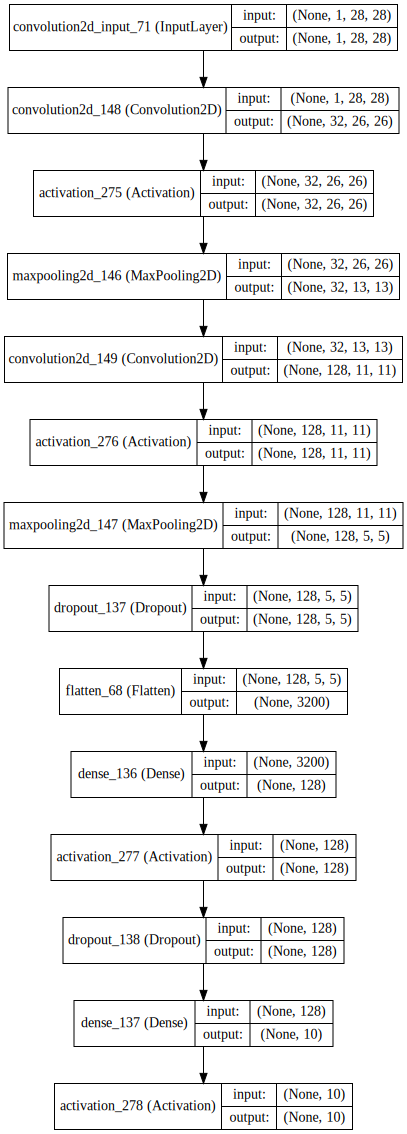

In [321]:
# visualizing the convnet

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True).create(prog='dot', format='svg'))

### Hyperparameter tuning

Check https://github.com/maxpumperla/hyperas

### Checking the misclassifications

9940 correct classifications
60 incorrect classifications


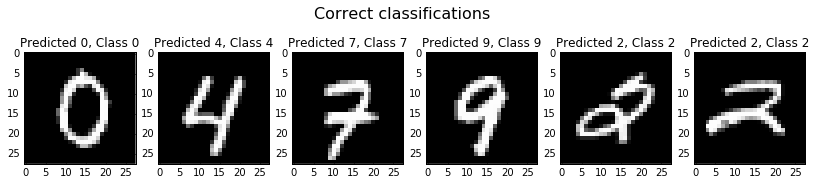

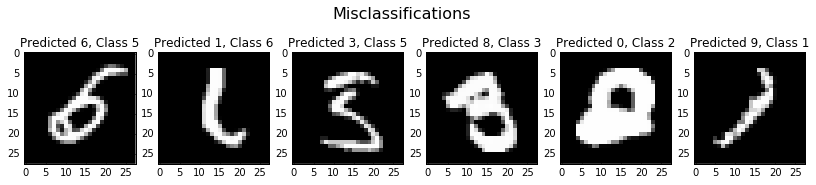

In [363]:
inspect_classification_results(model, X_test, y_test)

### Other optimizers

In [101]:
import keras
keras.__version__

'1.0.4'

In [102]:
from keras.optimizers import Nadam

ImportError: cannot import name Nadam

Now with Nadam optimizer (Nesterov Adam optimizer: Much like Adam is essentially RMSprop with momentum, Nadam is Adam RMSprop with Nesterov momentum). Does it change the LR?

Nadam report - http://cs229.stanford.edu/proj2015/054_report.pdf [2] On the importance of initialization and momentum in deep learning - - http://www.cs.toronto.edu/~fritz/absps/momentum.pdf

*Not yet **released**. I'll hae to come back and update keras*

# IRNN

This is a reproduction of the IRNN experiment
with pixel-by-pixel sequential MNIST in
"A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
by Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
arXiv:1504.00941v2 [cs.NE] 7 Apr 2015
http://arxiv.org/pdf/1504.00941v2.pdf
Optimizer is replaced with RMSprop which yields more stable and steady
improvement.
Reaches 0.93 train/test accuracy after 900 epochs
(which roughly corresponds to 1687500 steps in the original paper.)

In [47]:
from keras.layers import SimpleRNN
from keras.initializations import normal, identity


In [44]:
batch_size = 32
nb_classes = 10
hidden_units = 100

learning_rate = 1e-6
clip_norm = 1.0

In [45]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 784, 1)
60000 train samples
10000 test samples


In [48]:
print('Evaluate IRNN...')
model = Sequential()
model.add(SimpleRNN(output_dim=hidden_units,
                    init=lambda shape, name: normal(shape, scale=0.001, name=name),
                    inner_init=lambda shape, name: identity(shape, scale=1.0, name=name),
                    activation='relu',
                    input_shape=X_train.shape[1:]))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
rmsprop = RMSprop(lr=learning_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

Evaluate IRNN...


In [50]:
nb_epochs = 100

In [ ]:
%%time

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epochs,
          verbose=1, validation_data=(X_test, Y_test))

scores = model.evaluate(X_test, Y_test, verbose=0)
print('IRNN test score:', scores[0])
print('IRNN test accuracy:', scores[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 167s - loss: 1.9600 - acc: 0.2636 - val_loss: 1.8686 - val_acc: 0.3021
Epoch 2/100
60000/60000 [==============================] - 174s - loss: 1.7898 - acc: 0.3332 - val_loss: 1.6924 - val_acc: 0.4050
Epoch 3/100
60000/60000 [==============================] - 166s - loss: 1.6500 - acc: 0.4004 - val_loss: 1.5803 - val_acc: 0.4368
Epoch 4/100
60000/60000 [==============================] - 175s - loss: 1.5754 - acc: 0.4309 - val_loss: 1.5243 - val_acc: 0.4630
Epoch 5/100
60000/60000 [==============================] - 179s - loss: 1.5246 - acc: 0.4496 - val_loss: 1.5192 - val_acc: 0.4481
Epoch 6/100
60000/60000 [==============================] - 164s - loss: 1.4822 - acc: 0.4694 - val_loss: 1.4530 - val_acc: 0.4813
Epoch 7/100
60000/60000 [==============================] - 169s - loss: 1.4312 - acc: 0.4902 - val_loss: 1.3671 - val_acc: 0.5193
Epoch 8/100
60000/60000 [===============

In [52]:
print('IRNN test score:', scores[0])
print('IRNN test accuracy:', scores[1])

IRNN test score: 0.524374077368
IRNN test accuracy: 0.8147


Few hours training, very slow improve in accuracy... 100 epochs wasn't enough, apparently it needed 200 epochs.

# Overfeat

http://www.image-net.org/challenges/LSVRC/2013/slides/overfeat_ilsvrc2013.pdf

https://arxiv.org/pdf/1312.6229.pdf

An adaptation of the 'fast' model from AlexNet applied to MNIST-10.

In [337]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32') / 255
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [340]:
from keras.layers import ZeroPadding2D

In [341]:
model = Sequential()

# Layer 1
model.add(Convolution2D(96, 11, 11, input_shape = (1,28,28), border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Convolution2D(256, 5, 5, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, border_mode='same'))
model.add(Activation('relu'))

# Layer 4
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(1024, 3, 3, border_mode='same'))
model.add(Activation('relu'))

# Layer 5
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(1024, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Flatten())
model.add(Dense(3072, init='glorot_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 7
model.add(Dense(4096, init='glorot_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 8
model.add(Dense(10, init='glorot_normal'))
model.add(Activation('softmax'))

MemoryError: ('Error allocating 452984832 bytes of device memory (out of memory).', "you might consider using 'theano.shared(..., borrow=True)'")

training this model (even on MNIST-10) is quite time consuming

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam())
model.fit(X_train[:10], Y_train[:10], batch_size=1, nb_epoch=1,
          verbose=2, show_accuracy=True)

GPU not powerful enough???

# LENET-5, example of making a function of the CNN

http://codingplayground.blogspot.be/2016/05/demystifying-deep-learning-series-hands.html
http://codingplayground.blogspot.be/2016/05/demystifying-deep-learning-explaining.html

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1111)  # for reproducibility
  
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.regularizers import l2, activity_l2
from keras.utils.visualize_util import plot
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.callbacks import EarlyStopping
 
import inspect
 
#
# save the graph produced by the experiment
#
def print_Graph(fitlog, elapsed, args, values):
    """
    fitlog : Training log
    elapsed : elapsed time
    args : input parameters for the experiment
    values : input values for the experiment
    """
    experiment_label = "\n".join(['%s=%s' % (i, values[i]) for i in args])
    experiment_file = experiment_label+"-Time= %02d" % elapsed + "sec"
    experiment_file = experiment_file.replace("\n", "-")+'.png'

    fig = plt.figure(figsize=(10, 6))
    plt.plot(fitlog.history["val_acc"])
    plt.title('val_accuracy')
    plt.ylabel('val_accuracy')
    plt.xlabel('iteration')
    fig.text(.7,.15,experiment_label, size='6')
    plt.savefig(experiment_file, format="png")
    
    
#
# A LeNet-like convnet for classifying MINST handwritten characters 28x28
#
def convNet_LeNet(VERBOSE=1, NORMALIZE=True, BATCH_SIZE=128, NUM_EPOCHS=12,
                  NUM_FILTERS=32, NUM_POOL=2, NUM_CONV=3, DROPOUT_RATE=0.5,
                  NUM_HIDDEN=128, VALIDATION_SPLIT=0.2,
                  OPTIMIZER=SGD(lr=0.01,decay=1e-6,
                                momentum=0.9,nesterov=True)):
    """
    NUM_FILTERS : Number of convolutional filters 
    NUM_POOL : side length of maxpooling square
    NUM_CONV : side length of convolution square
    DROPOUT_RATE : dropout rate for regularization
    NUM_HIDDEN : hidden number of neurons first layer
    VALIDATION_SPLIT : validation data
    """ 
    # Output classes, number of MINST DIGITS
    NUM_CLASSES = 10
    # Shape of an MINST digit image
    SHAPE_X, SHAPE_Y = 28, 28
    # Channels on MINST
    IMG_CHANNELS = 1

    # LOAD the MINST DATA split in training and test data
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 1, SHAPE_X, SHAPE_Y)
    X_test = X_test.reshape(X_test.shape[0], 1, SHAPE_X, SHAPE_Y)

    # convert in float32 representation for GPU computation
    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")

    if (NORMALIZE):
        # NORMALIZE each pixerl by dividing by max_value=255
        X_train /= 255
        X_test /= 255
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # KERAS needs to represent each output class into OHE representation
    Y_train = np_utils.to_categorical(Y_train, NUM_CLASSES)
    Y_test = np_utils.to_categorical(Y_test, NUM_CLASSES)

    nn = Sequential()

    #FIRST LAYER OF CONVNETS, POOLING, DROPOUT
    #  apply a NUM_CONV x NUM_CONF convolution with NUM_FILTERS output
    #  for the first layer it is also required to define the input shape
    #  activation function is rectified linear 
    nn.add(Convolution2D(NUM_FILTERS, NUM_CONV, NUM_CONV, 
    input_shape=(IMG_CHANNELS, SHAPE_X, SHAPE_Y) ))
    nn.add(Activation('relu'))
    nn.add(Convolution2D(NUM_FILTERS, NUM_CONV, NUM_CONV))
    nn.add(Activation('relu'))
    nn.add(MaxPooling2D(pool_size = (NUM_POOL, NUM_POOL)))
    nn.add(Dropout(DROPOUT_RATE))

    #SECOND LAYER OF CONVNETS, POOLING, DROPOUT 
    #  apply a NUM_CONV x NUM_CONF convolution with NUM_FILTERS output
    nn.add(Convolution2D( NUM_FILTERS, NUM_CONV, NUM_CONV))
    nn.add(Activation('relu'))
    nn.add(Convolution2D(NUM_FILTERS, NUM_CONV, NUM_CONV))
    nn.add(Activation('relu'))
    nn.add(MaxPooling2D(pool_size = (NUM_POOL, NUM_POOL) ))
    nn.add(Dropout(DROPOUT_RATE))

    # FLATTEN the shape for dense connections 
    nn.add(Flatten())

    # FIRST HIDDEN LAYER OF DENSE NETWORK
    nn.add(Dense(NUM_HIDDEN))  
    nn.add(Activation('relu'))
    nn.add(Dropout(DROPOUT_RATE))          

    # OUTFUT LAYER with NUM_CLASSES OUTPUTS
    # ACTIVATION IS SOFTMAX, REGULARIZATION IS L2
    nn.add(Dense(NUM_CLASSES, W_regularizer=l2(0.01) ))
    nn.add(Activation('softmax') )

    #summary
    nn.summary()
    #plot the model
    plot(nn)

    # set an early-stopping value
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)

    # COMPILE THE MODEL
    #   loss_function is categorical_crossentropy
    #   optimizer is parametric
    nn.compile(loss='categorical_crossentropy', 
    optimizer=OPTIMIZER, metrics=["accuracy"])

    start = time.time()
    # FIT THE MODEL WITH VALIDATION DATA
    fitlog = nn.fit(X_train, Y_train, \
    batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS, \
    verbose=VERBOSE, validation_split=VALIDATION_SPLIT, \
    callbacks=[early_stopping])
    elapsed = time.time() - start

    # Test the network
    results = nn.evaluate(X_test, Y_test, verbose=VERBOSE)
    print('accuracy:', results[1])

    # just to get the list of input parameters and their value
    frame = inspect.currentframe()
    args, _, _, values = inspect.getargvalues(frame)
    # used for printing pretty arguments

    print_Graph(fitlog, elapsed, args, values)

    return fitlog  

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_17 (Convolution2D) (None, 32, 26, 26)    320         convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 32, 26, 26)    0           convolution2d_17[0][0]           
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 32, 24, 24)    9248        activation_37[0][0]              
____________________________________________________________________________________________________
activation_38 (Activation)       (None, 32, 24, 24)    0           convolution2d_18[0][0]           
__________________

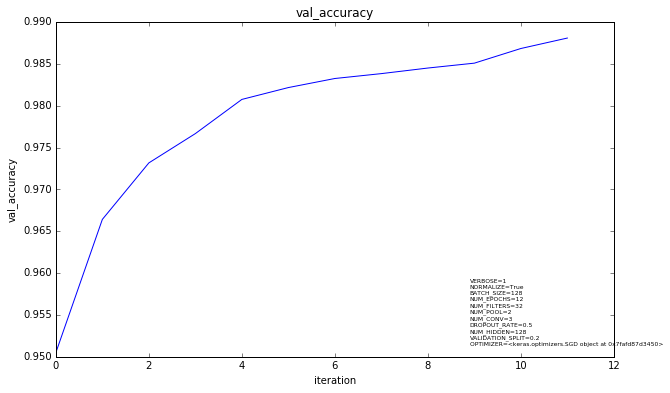

In [80]:
%%time

convNet_LeNet(VERBOSE=1, NORMALIZE=True, BATCH_SIZE=128, NUM_EPOCHS=12,
                  NUM_FILTERS=32, NUM_POOL=2, NUM_CONV=3, DROPOUT_RATE=0.5,
                  NUM_HIDDEN=128, VALIDATION_SPLIT=0.2,
                  OPTIMIZER=SGD(lr=0.01,decay=1e-6,
                                momentum=0.9,nesterov=True))